In [1]:
%matplotlib notebook

# A better Dropout! Implementing DropBlock in PyTorch


## Introduction
Ghiasi et al. introduce [DropBlock](https://arxiv.org/abs/1810.12890), a regularization technique specifically crafter for images that works better than Dropout. 

<!-- This is an **old paper**, but I think it is very interesting to show off the thinking behind it and how to implement it. -->

## The problem with Dropout with images
[Dropout](https://jmlr.org/papers/v15/srivastava14a.html) is a regularization technique that randomly drops (set to zeros) parts of the the input before passing it to the next layer. If you are not familiar with it, I suggest the [this](https://cs231n.github.io/neural-networks-2/) lecture notes form standfort (jump to the dropout section).

Dropout is already implemented in PyTorch

tensor(256.)
tensor(238.)


<IPython.core.display.Javascript object>


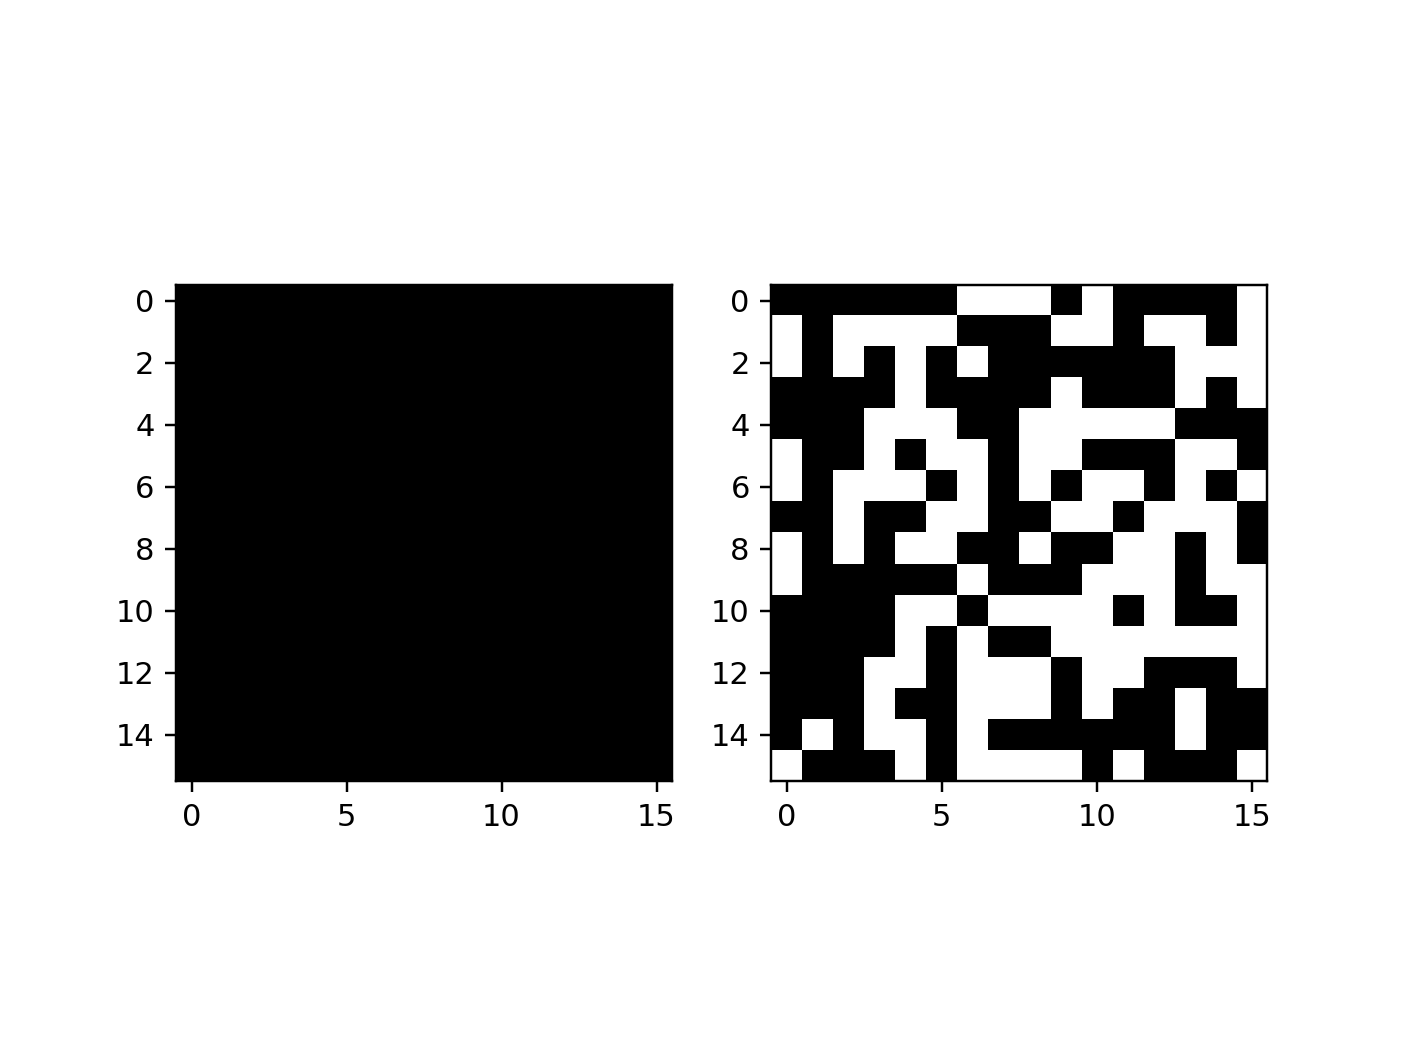

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn

# keeping one channel for better visualisation
x = torch.ones((1, 1, 16, 16))

drop = nn.Dropout()
x_drop = drop(x)

to_plot = lambda x: x.squeeze(0).permute(1,2,0).numpy()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(to_plot(x), cmap='gray')
axs[1].imshow(to_plot(x_drop), cmap='gray')

As you can see, random part of the input was dropped!

This tecnique works well on 1D data, but with 2D data we can do better. The **main issue** is that we are dropping indipend pixels and this *is not effective in removing semantic information because nearby activations contain
closely related information*. I think this is fairly intuitive, even if we zero out one element, the neighbours can still carry out important informations.

Let's see an example

In [3]:
import requests
from glasses.models import AutoModel, AutoTransform
from PIL import Image
from io import BytesIO

# get an image of baby yoda
r = requests.get('https://upload.wikimedia.org/wikipedia/en/0/00/The_Child_aka_Baby_Yoda_%28Star_Wars%29.jpg')
img = Image.open(BytesIO(r.content))
# use glasses to transform it to the right format
x = AutoTransform.from_name('resnet18')(img)
# get a pretrained resnet18
model = AutoModel.from_pretrained('resnet18').eval()

with torch.no_grad():
    model.encoder.features
    model(x.unsqueeze(0))
    features = model.encoder.features
    # features is a list of layer's outputs 

/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<IPython.core.display.Javascript object>


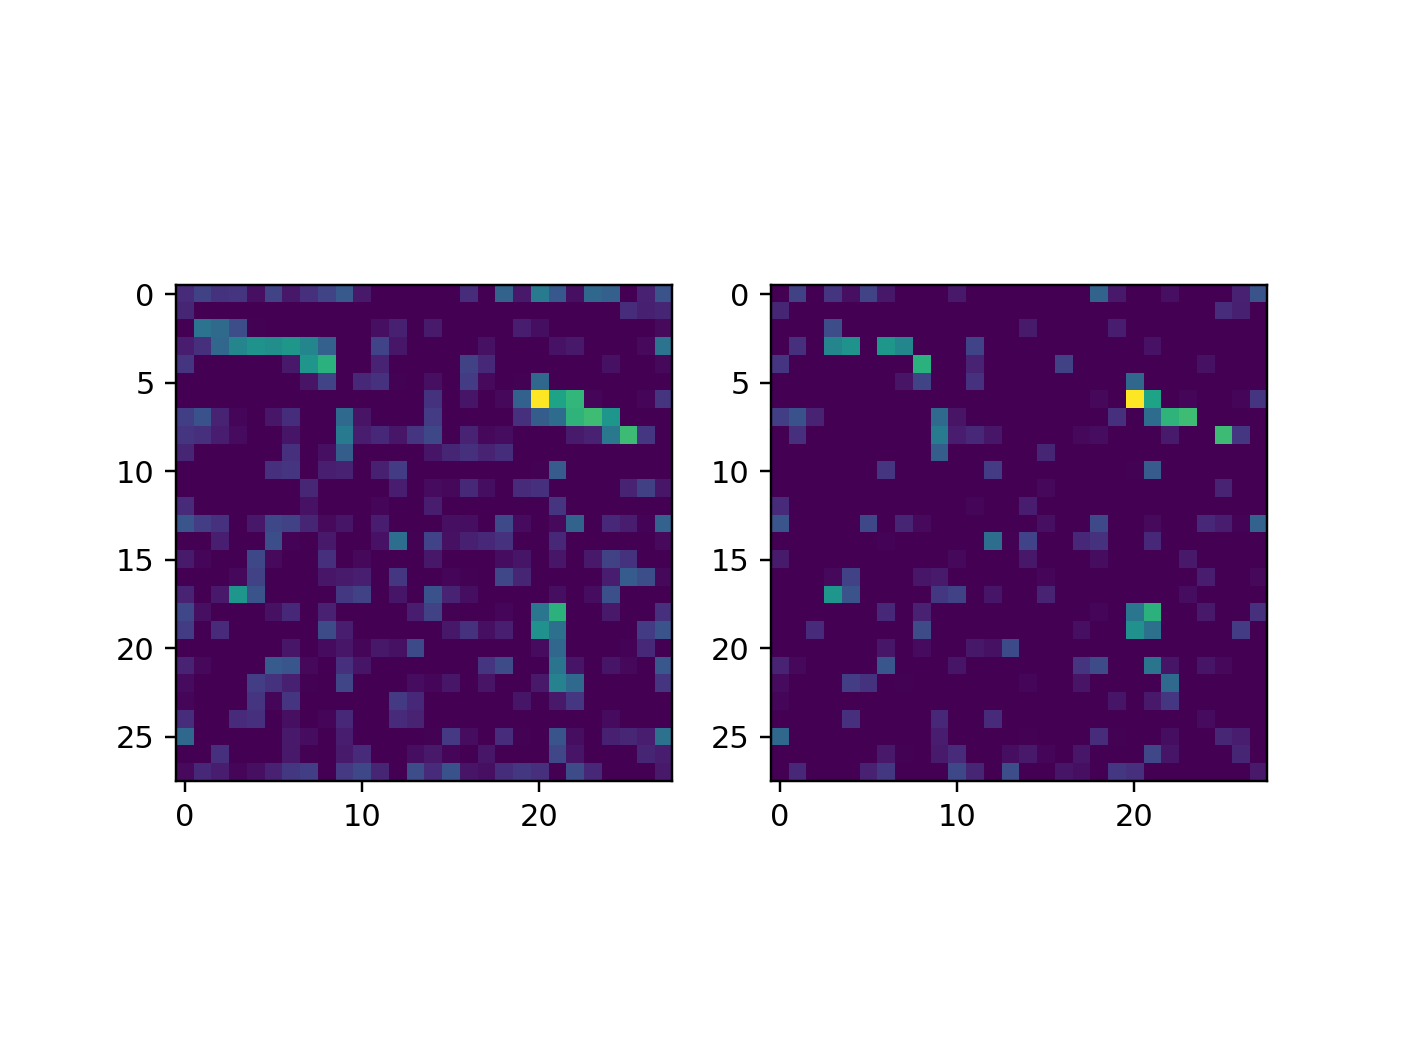

In [4]:
# take the feature from the third layer -> [1, 128, 28, 28]
f = features[2]
# aplpy dropout + relu
f_drop = nn.Sequential(
    nn.Dropout(),
    nn.ReLU())(f)
# apply only relu 
f_l = nn.ReLU()(f)
# get first channel
f_l = f_l[:,0,:,:]
f_drop_l = f_drop[:,0,:,:]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(f_l.squeeze().numpy())
axs[1].imshow(f_drop_l.squeeze().numpy())

As we can see, if we apply dropout + activation to an image that encodes semantic information we still have neurons closed to the zerod ones that fires. Thus, information is propagated to the next layer.

## DropBlock

DropBlock solves this problem by dropping continous regions from a feature map, the following figure shows the main idea.

![img](./images/1.png)

Dropblock works as follow

![img](./images/2.png)

Let's go step by step

Let's first define a `DropBlock` layer with the correct parameters

In [5]:
from torch import nn
import torch
from torch import Tensor

class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        self.block_size = block_size
        self.p = p

`block_size` is the size of each region we are going to drop from an input, `p` is the `keep_prob` like in `Dropout`.

So far so good. Now the tricky part, we need to compute gamma that controls the features to drop. If we want to keep every activation with `p` prob, we can sample from a Bernoulli distribution with mean `1 - p` like in Dropout. The problem is we are setting to zeros `block_size ** 2` units.

Gamma is computed using


\begin{equation}
\gamma=\frac{1-\text { keep_prob }}{\text { block_size }^{2}} \frac{\text { feat_size }^{2}}{(\text { feat_size }-\text { block_size }+1)^{2}}
\end{equation}

The first part is the number of units that will be set to zero.

The second part is the valid region, the number of pixels not touched by dropblock


In [6]:
class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        self.block_size = block_size
        self.p = p


    def calculate_gamma(self, x: Tensor) -> float:
        """Compute gamma, eq (1) in the paper
        Args:
            x (Tensor): Input tensor
        Returns:
            Tensor: gamma
        """
        
        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid
    
x = torch.ones(1, 8, 16, 16)
DropBlock(block_size=2).calculate_gamma(x)

0.14222222222222222

Next step is to sample a mask $M$ with the same size as the input from a Bernoulli distribution with center gamma, in PyTorch is as easy as

```
# x is the input
gamma = self.calculate_gamma(x)
mask = torch.bernoulli(torch.ones_like(x) * gamma)
```

Next, we need to zero out region of size `block_size`. We can use **max pool** with `kernel_size` equal to `block_size` and one pixel stride to create. Remember that mask is a binary mask (only 0s and 1s) so when maxpool sees a 1 in his kernel_size radius it will output a one, by using a 1 stride we ensure that in the output a region of size `block_size x block_size` is created if at least one unit in the input was set to 1. Since we want to zero them out, we need to invert it. In PyTorch


```
mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            
```

Then we normalize

```
x = mask_block * x * (mask_block.numel() / mask_block.sum())
```

In [7]:
import torch.nn.functional as F

class DropBlock(nn.Module):
    def __init__(self, block_size: int, p: float = 0.5):
        super().__init__()
        self.block_size = block_size
        self.p = p


    def calculate_gamma(self, x: Tensor) -> float:
        """Compute gamma, eq (1) in the paper
        Args:
            x (Tensor): Input tensor
        Returns:
            Tensor: gamma
        """
        
        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid



    def forward(self, x: Tensor) -> Tensor:
        if self.training:
            gamma = self.calculate_gamma(x)
            mask = torch.bernoulli(torch.ones_like(x) * gamma)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x

            

Let's test it with baby yoda, for simplicity, we are going to show the dropped unit in the first channel

<IPython.core.display.Javascript object>


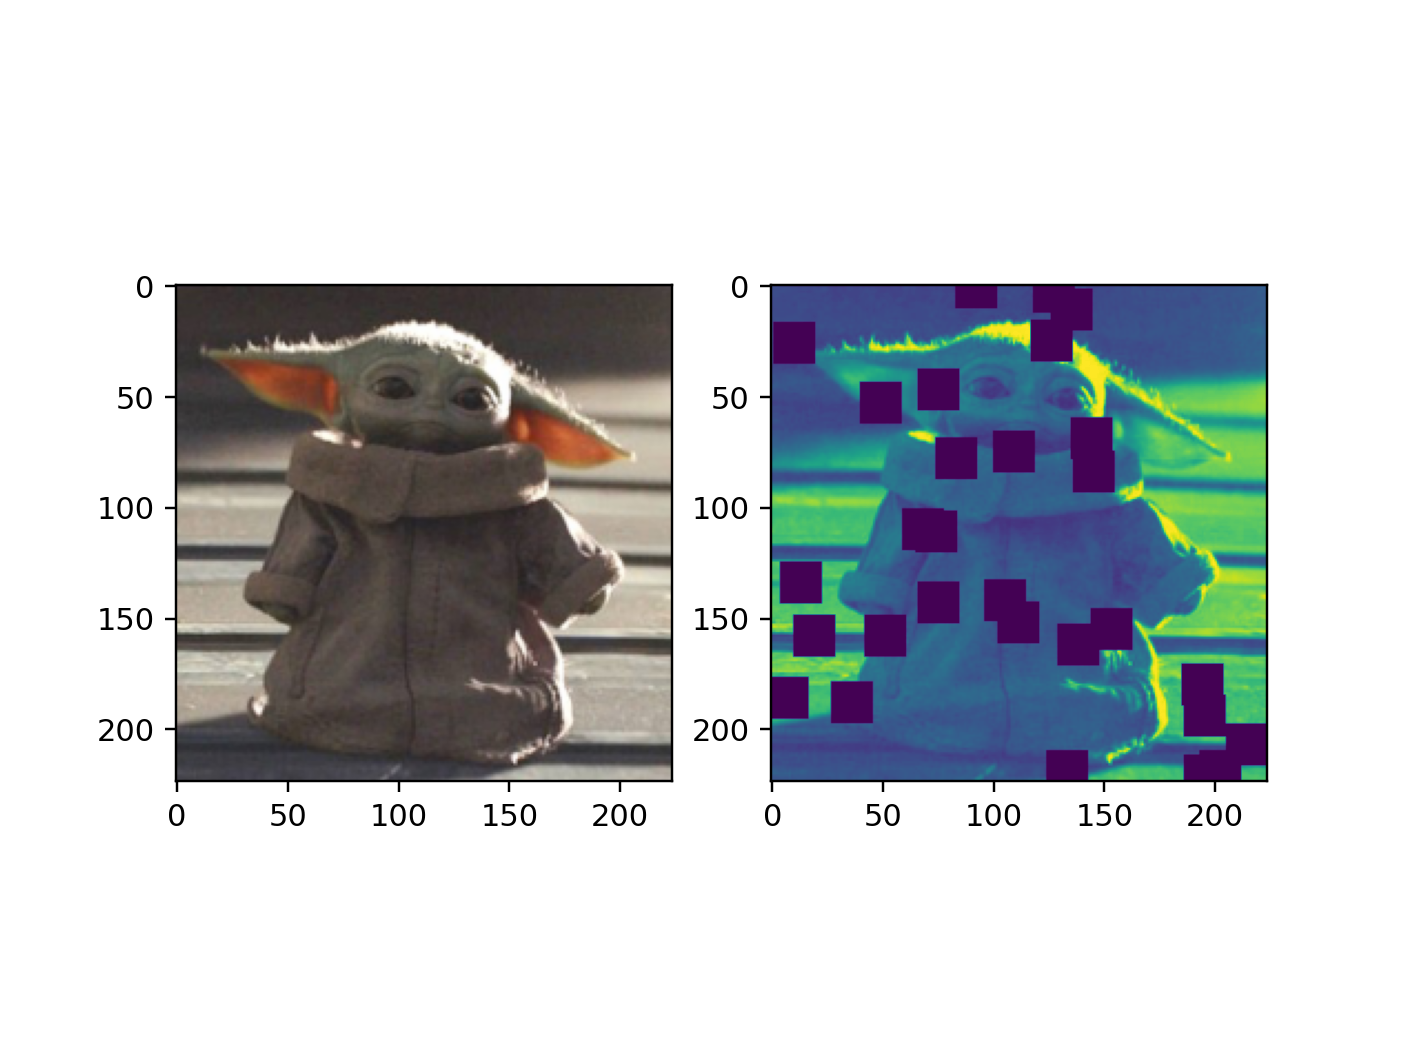

In [8]:
import torchvision.transforms as T
# get an image of baby yoda
r = requests.get('https://upload.wikimedia.org/wikipedia/en/0/00/The_Child_aka_Baby_Yoda_%28Star_Wars%29.jpg')
img = Image.open(BytesIO(r.content))
tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
x = tr(img)
drop_block = DropBlock(block_size=19, p=0.8)
x_drop = drop_block(x)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(to_plot(x))
axs[1].imshow(x_drop[0,:,:].squeeze().numpy())

Looking good, let's see a feature map from a pretrained model

<IPython.core.display.Javascript object>


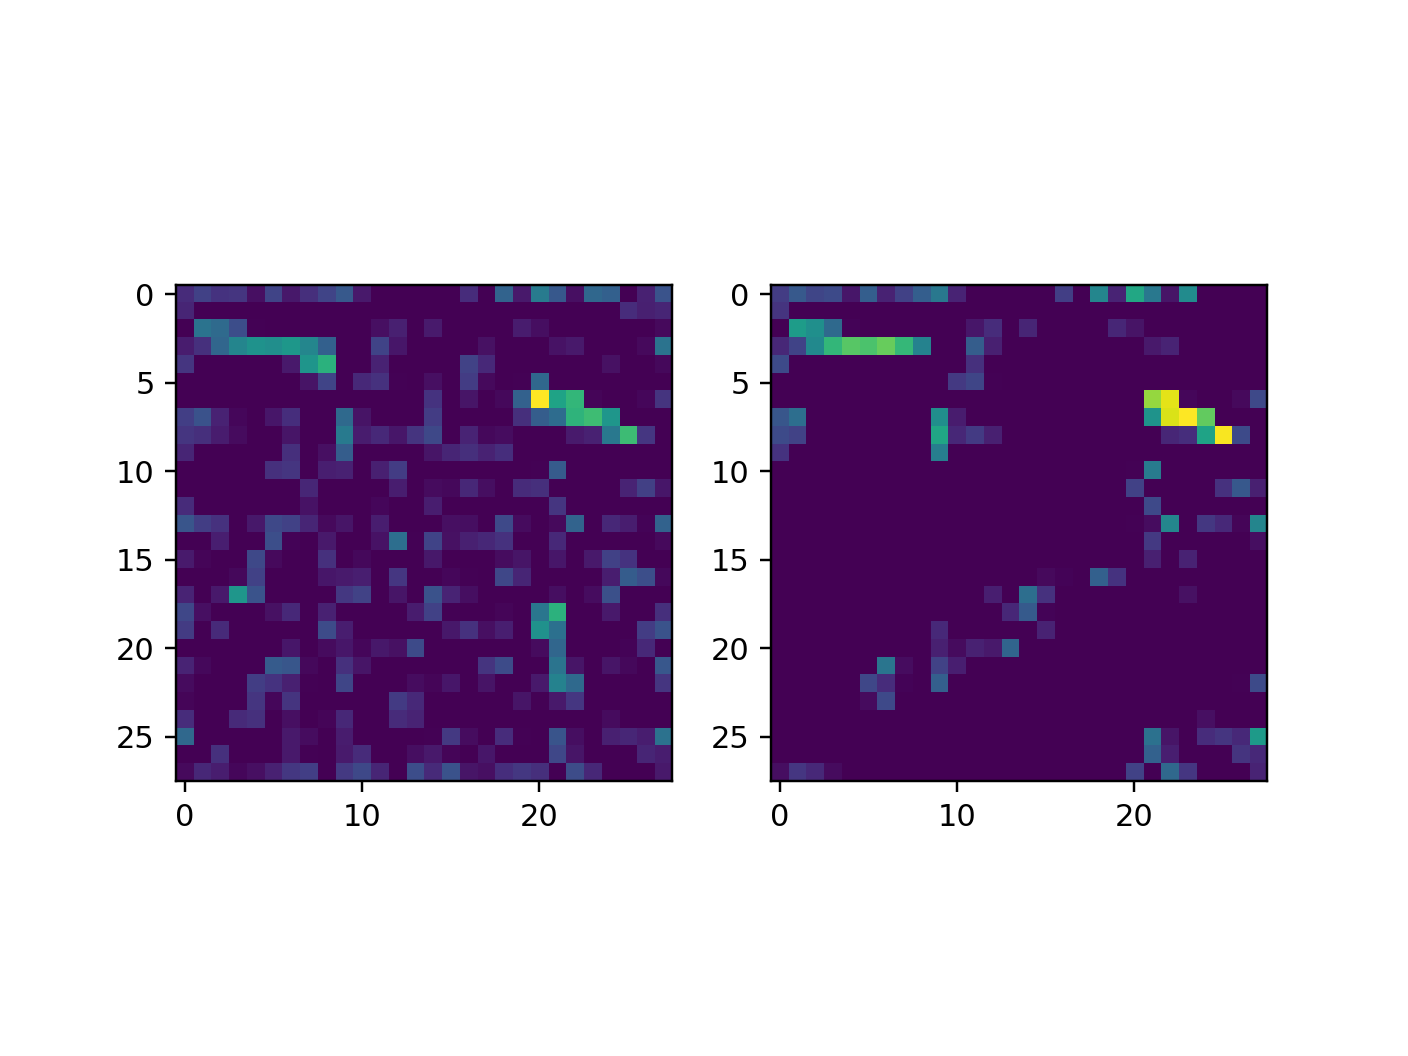

In [9]:
# take the feature from the third layer -> [1, 128, 28, 28]
f = features[2]
# aplpy dropout + relu
f_drop = nn.Sequential(
    DropBlock(block_size=7, p=0.5),
    nn.ReLU())(f)
# apply only relu 
f_l = nn.ReLU()(f)
# get first channel
f_l = f_l[:,0,:,:]
f_drop_l = f_drop[:,0,:,:]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(f_l.squeeze().numpy())
axs[1].imshow(f_drop_l.squeeze().numpy())

As you can see, we sucessuflly zero out continuous regions and not only individual unit.

By the way, `DropBlock` is equal to `Dropout` when `block_size = 1` and to `Dropout2d`(aka SpatialDropout) when `block_size` is the full feature map. 